In [1]:
#For importing modules
import sys


# final pre-processing
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from tensorflow.keras.utils import Sequence
import numpy as np


# model
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, BatchNormalization

# evaluation
from sklearn.metrics import precision_score, recall_score, confusion_matrix,classification_report,roc_curve, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
sys.path.append('/path/to/2014_07_13_test')
import generate_input

## Load data

In [3]:
# filter small cases
filter_case = ['case_00018', 'case_00031', 'case_00042', 'case_00056', 'case_00088', 'case_00090', 'case_00092', 
               'case_00106', 'case_00120', 'case_00133', 'case_00183', 'case_00200', 'case_00211', 'case_00228',
               'case_00234', 'case_00237', 'case_00249', 'case_00277', 'case_00288', 'case_00291']

In [4]:
# load validation set
val_case = ['case_00233', 'case_00089', 'case_00050', 'case_00112', 'case_00258', 'case_00246', 'case_00157',
            'case_00149','case_00184']
test_case = ['case_00221', 'case_00259', 'case_00087', 'case_00254', 'case_00098', 'case_00023', 'case_00041',
             'case_00080', 'case_00101', 'case_00164', 'case_00002', 'case_00110', 'case_00030', 'case_00068',
             'case_00026', 'case_00063', 'case_00006', 'case_00048', 'case_00250', 'case_00238', 'case_00015',
             'case_00111', 'case_00278', 'case_00133', 'case_00284', 'case_00282', 'case_00269', 'case_00039',
             'case_00033', 'case_00108', 'case_00175', 'case_00161', 'case_00256', 'case_00119', 'case_00286',
             'case_00077', 'case_00162', 'case_00270', 'case_00271', 'case_00285', 'case_00174', 'case_00147',
             'case_00215', 'case_00150', 'case_00052', 'case_00231', 'case_00198', 'case_00117', 'case_00138',
             'case_00211', 'case_00190', 'case_00248', 'case_00235', 'case_00049', 'case_00074', 'case_00107',
             'case_00218', 'case_00001', 'case_00193', 'case_00067', 'case_00289', 'case_00072', 'case_00044',
             'case_00294', 'case_00298', 'case_00263', 'case_00038', 'case_00299', 'case_00249', 'case_00225',
             'case_00217', 'case_00178', 'case_00082', 'case_00035', 'case_00034', 'case_00047', 'case_00276',
             'case_00151', 'case_00226', 'case_00086', 'case_00176']

In [5]:
all_cases = [ 'case_' + str(number).zfill(5) for number in range(300)] # create list of all cases
train_case = [x for x in all_cases if x not in val_case and x not in test_case] # take only cases not in test and val

In [6]:
def generate_part_label_dict(labels_dict, list_of_cases):
    return {k: labels_dict[k] for k in list_of_cases}

def load_data(rootdir, img_dir, json_path, list_cases):
    val_path = generate_input.processed_image_paths(rootdir, img_dir)
    labels_dict = generate_input.malignant_labels_to_dict(json_path)
    labels_dict_short = generate_part_label_dict(labels_dict, list_cases)
    image_dict_short = generate_input.load_nifti_img_and_mask_as_numpy(val_path, list_cases)
    x_set, y_set = generate_input.fill_set(list_cases, labels_dict_short, image_dict_short, labels_dict)
    x_set = generate_input.adding_channel(x_set)
    return x_set, y_set

In [23]:
x_val, y_val = load_data('./preprocessed-data/', 'images', '../kits21/kits21/data/kits.json', val_case)
x_test, y_test = load_data('./preprocessed-data/', 'images', '../kits21/kits21/data/kits.json', test_case)

In [24]:
x_train, y_train = load_data('./preprocessed-data/', 'images', '../kits21/kits21/data/kits.json', train_case)

In [9]:
# x_train, y_train, x_val, y_val, x_test, y_test, id_val, id_test = generate_input.generate_data_input(
#     '../kits21/kits21/data/kits.json', n_samples = 300, neg_pct = 100, rootdir = './preprocessed-data/', 
#     img_dir = 'images', mask_dir = 'masks', val_split = 9, test_split = 81)

## Upsampling 

In [10]:
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
sm = SMOTE(random_state=64)
x_smote, y_smote = sm.fit_resample(x_train_reshape, y_train)
x_smote = x_smote.reshape(x_smote.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3])

In [11]:
x_smote, y_smote = shuffle(x_smote, y_smote)

## Developing baseline model

In [12]:
# a code is taken from https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor

batch_size = 32
class DataGenerator(Sequence):
    """ Send data to the model using TF in specified sizes of batch """
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(x_smote, y_smote, batch_size)

In [13]:
# draft model
#inputs = Input(shape=(224, 224, 3))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=2)

resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(128,128,3))

for layer in resnet.layers[:170]:
    layer.trainable = False

metrics_list = [tf.keras.metrics.AUC(name = 'auc'),
                tf.keras.metrics.BinaryAccuracy(name = 'accuracy')]

#calculate class weights
class_weights = {0 : 25, 1 : 1} 

optimizer_fn = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001, jit_compile = False)
#optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.00002)

x = Flatten()(resnet.output)
x = Dense(1024, activation = 'relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu', kernel_regularizer='l2')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(resnet.input, x)

model.compile(optimizer = optimizer_fn, loss='binary_crossentropy', metrics= metrics_list)
model.summary()
model.fit(train_gen, validation_data = (x_val, y_val), epochs=5, batch_size = batch_size, class_weight = class_weights)


2023-05-01 22:34:51.528070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-01 22:34:51.530217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256    

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

2023-05-01 22:34:53.006145: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-01 22:34:54.410394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2599/2599 [==============================] - ETA: 0s - loss: 2.2698 - auc: 0.7323 - accuracy: 0.6201

2023-05-01 22:38:21.339090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2599/2599 [==============================] - 212s 80ms/step - loss: 2.2698 - auc: 0.7323 - accuracy: 0.6201 - val_loss: 0.6682 - val_auc: 0.1342 - val_accuracy: 0.9423
Epoch 2/5
2599/2599 [==============================] - 206s 79ms/step - loss: 1.5042 - auc: 0.9026 - accuracy: 0.7485 - val_loss: 1.1300 - val_auc: 0.5000 - val_accuracy: 0.9423
Epoch 3/5
2599/2599 [==============================] - 206s 79ms/step - loss: 1.2490 - auc: 0.9474 - accuracy: 0.8167 - val_loss: 0.6097 - val_auc: 0.8723 - val_accuracy: 0.9079
Epoch 4/5
2599/2599 [==============================] - 206s 79ms/step - loss: 1.1407 - auc: 0.9615 - accuracy: 0.8522 - val_loss: 1.4308 - val_auc: 0.5000 - val_accuracy: 0.9423
Epoch 5/5
2599/2599 [==============================] - 206s 79ms/step - loss: 1.0819 - auc: 0.9674 - accuracy: 0.8737 - val_loss: 1.1430 - val_auc: 0.5000 - val_accuracy: 0.9423


In [14]:
results = model.evaluate(x_val, y_val)
results

58/58 [==============================] - 3s 45ms/step - loss: 1.1430 - auc: 0.5000 - accuracy: 0.9423


[1.1429623365402222, 0.5, 0.9423491358757019]

In [25]:
y_pred = loaded_model.predict(x_val)

21/21 [==============================] - 1s 48ms/step


In [26]:
precision = precision_score(y_val, y_pred.round()) 
recall = recall_score(y_val, y_pred.round())
print(precision)
print(recall)

0.966
0.7957166392092258


In [27]:
confusion_matrix(y_val, y_pred.round())

array([[ 21,  17],
       [124, 483]])

In [28]:
print(classification_report(y_val, y_pred.round(), digits = 4)) 

              precision    recall  f1-score   support

         0.0     0.1448    0.5526    0.2295        38
         1.0     0.9660    0.7957    0.8726       607

    accuracy                         0.7814       645
   macro avg     0.5554    0.6742    0.5511       645
weighted avg     0.9176    0.7814    0.8347       645



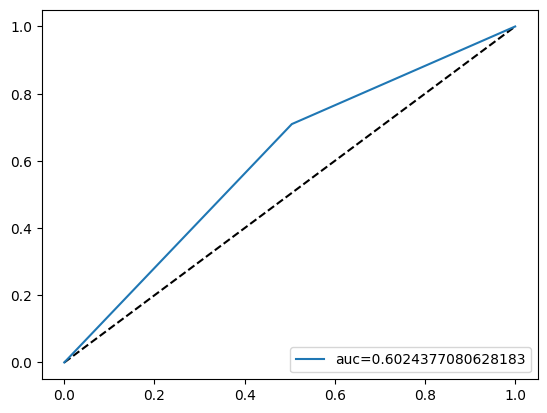

In [68]:
fpr, tpr, _ = roc_curve(y_val,  y_pred.round())
auc = roc_auc_score(y_val, y_pred.round())
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Evaluation of test set

In [30]:
y_pred_test = loaded_model.predict(x_test)

193/193 [==============================] - 8s 39ms/step


In [31]:
confusion_matrix(y_test, y_pred_test.round())

array([[  84,  171],
       [1753, 4143]])

In [32]:
print(classification_report(y_test, y_pred_test.round(), digits = 4))

              precision    recall  f1-score   support

         0.0     0.0457    0.3294    0.0803       255
         1.0     0.9604    0.7027    0.8116      5896

    accuracy                         0.6872      6151
   macro avg     0.5030    0.5160    0.4459      6151
weighted avg     0.9224    0.6872    0.7812      6151



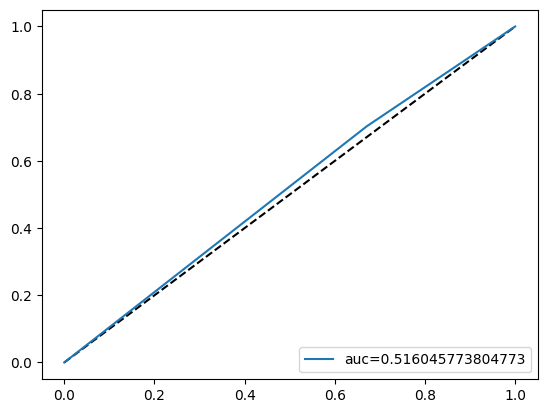

In [33]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_test.round())
auc = roc_auc_score(y_test, y_pred_test.round())
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Save model

In [29]:
model_json = model.to_json()
with open("model1_binary2.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model1_binary2.h5")

## Load model

In [8]:
# load json and create model
json_file = open('baseline_model/model1_binary2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("baseline_model/model1_binary2.h5")

2023-05-02 09:49:24.351807: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-02 09:49:24.351932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


In [9]:
# evaluate loaded model on test data
optimizer_fn = tf.keras.optimizers.experimental.RMSprop(learning_rate=0.001, jit_compile = False)
metrics_list = [tf.keras.metrics.AUC(name = 'auc'),
                tf.keras.metrics.BinaryAccuracy(name = 'accuracy')]
loaded_model.compile(optimizer = optimizer_fn, loss='binary_crossentropy', metrics= metrics_list)
score1 = loaded_model.evaluate(x_val, y_val)
score1

2023-05-02 09:49:25.344408: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-02 09:49:25.651427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 3s 64ms/step - loss: 0.8263 - auc: 0.7810 - accuracy: 0.7814


[0.8263449668884277, 0.7810196876525879, 0.7813953757286072]

## Majority voting

In [34]:
# load validation set
val_case = ['case_00233', 'case_00089', 'case_00050', 'case_00112', 'case_00258', 'case_00246', 'case_00157', 'case_00149','case_00184']
test_case = ['case_00221', 'case_00259', 'case_00087', 'case_00254', 'case_00098', 'case_00023', 'case_00041',
             'case_00080', 'case_00101', 'case_00164', 'case_00002', 'case_00110', 'case_00030', 'case_00068',
             'case_00026', 'case_00063', 'case_00006', 'case_00048', 'case_00250', 'case_00238', 'case_00015',
             'case_00111', 'case_00278', 'case_00133', 'case_00284', 'case_00282', 'case_00269', 'case_00039',
             'case_00033', 'case_00108', 'case_00175', 'case_00161', 'case_00256', 'case_00119', 'case_00286',
             'case_00077', 'case_00162', 'case_00270', 'case_00271', 'case_00285', 'case_00174', 'case_00147',
             'case_00215', 'case_00150', 'case_00052', 'case_00231', 'case_00198', 'case_00117', 'case_00138',
             'case_00211', 'case_00190', 'case_00248', 'case_00235', 'case_00049', 'case_00074', 'case_00107',
             'case_00218', 'case_00001', 'case_00193', 'case_00067', 'case_00289', 'case_00072', 'case_00044',
             'case_00294', 'case_00298', 'case_00263', 'case_00038', 'case_00299', 'case_00249', 'case_00225',
             'case_00217', 'case_00178', 'case_00082', 'case_00035', 'case_00034', 'case_00047', 'case_00276',
             'case_00151', 'case_00226', 'case_00086', 'case_00176']

In [35]:
def adding_channel_dict(image_dict):
    """Convert from one channel to three channel images that are stored in dictionary """
    for key in image_dict:
        image_dict[key] = generate_input.adding_channel(image_dict[key])
    return image_dict

def load_data_to_evaluate_by_majority_voting(rootdir, img_dir, json_path, list_cases):
    """ Load images and labels in dictionary format """
    val_path = generate_input.processed_image_paths(rootdir, img_dir)
    labels_dict = generate_input.malignant_labels_to_dict(json_path)
    labels_dict_short = generate_part_label_dict(labels_dict, list_cases)
    labels_dict_short = {key: float(value) for key, value in labels_dict_short.items()}
    
    image_dict_short = generate_input.load_nifti_img_and_mask_as_numpy(val_path, list_cases)
    image_dict_short = adding_channel_dict(image_dict_short)
    return image_dict_short, labels_dict_short
    
def create_prediction_dict(image_dict, model):
    """ Create dictionary with prediction on patient-level using majority voting """
    pred_dict = {}
    for key in image_dict:
        y_pred = model.predict(image_dict[key])
        pred_dict[key] = np.round(np.sum(y_pred)/len(y_pred))
    return pred_dict

def create_true_and_prediction_lists(true_dict, pred_dict):
    """ Convert dictionaries into lists for evaluation """
    common_keys = true_dict.keys() & pred_dict.keys()
    true_lst = []
    pred_lst = [] 
    for key in common_keys:
        true_lst.append(true_dict[key])
        pred_lst.append(pred_dict[key])   
    return true_lst, pred_lst

### Validation set

In [36]:
val_dict, labels_val = load_data_to_evaluate_by_majority_voting('./preprocessed-data/', 'images', '../kits21/kits21/data/kits.json', val_case)

In [37]:
val_pred_dict = create_prediction_dict(val_dict, loaded_model)

1/1 [==============================] - 1s 517ms/step


In [38]:
val_true_lst, val_pred_lst = create_true_and_prediction_lists(labels_val, val_pred_dict)

In [39]:
print(confusion_matrix(val_true_lst, val_pred_lst))

[[1 0]
 [1 7]]


In [40]:
print(classification_report(val_true_lst, val_pred_lst))

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67         1
         1.0       1.00      0.88      0.93         8

    accuracy                           0.89         9
   macro avg       0.75      0.94      0.80         9
weighted avg       0.94      0.89      0.90         9



### Test set

In [41]:
test_dict, test_label_dict = load_data_to_evaluate_by_majority_voting('./preprocessed-data/', 'images', '../kits21/kits21/data/kits.json', test_case)

In [42]:
test_pred_dict = create_prediction_dict(test_dict, loaded_model)

1/1 [==============================] - 0s 25ms/step


In [43]:
test_true_lst, test_pred_lst = create_true_and_prediction_lists(test_label_dict, test_pred_dict)

In [44]:
print(confusion_matrix(test_true_lst, test_pred_lst))

[[ 2  5]
 [16 58]]


In [45]:
print(classification_report(test_true_lst, test_pred_lst, digits = 4))

              precision    recall  f1-score   support

         0.0     0.1111    0.2857    0.1600         7
         1.0     0.9206    0.7838    0.8467        74

    accuracy                         0.7407        81
   macro avg     0.5159    0.5347    0.5034        81
weighted avg     0.8507    0.7407    0.7874        81

